In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
%run Mask-Utils.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
TEXTURE_SIZE = 400

In [46]:
face_boxes, tddfa = load_models()
predictor = get_vertices_predictor(face_boxes, tddfa)

___

  0%|          | 0/13234 [00:00<?, ?it/s]

/home/darusik/datasets/lfw/lfw_mtcnnpy_160/bounding_boxes_04214.txt
/home/darusik/datasets/lfw/lfw_mtcnnpy_160/David_Coulthard/David_Coulthard_0001.png
/home/darusik/datasets/lfw/lfw_mtcnnpy_160/David_Coulthard/David_Coulthard_1001.png


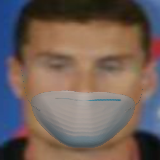

  0%|          | 1/13234 [00:31<116:18:19, 31.64s/it]


In [51]:
from pathlib import Path
from skimage.io import imread
from random import choice
from tqdm import tqdm

paths = Path('~/datasets/lfw/lfw_mtcnnpy_160').expanduser().glob('**/*_0*.*')

for path in tqdm(list(paths)):
    image_path = str(path)
    print(image_path)
    new_image_path = image_path.replace("_0", "_1")
    if Path(new_image_path).is_file():
        continue
    
    image = cv2.imread(image_path)
    if image is None:
        continue
    
    ver = predictor(image)
    
    texture = uv_tex(image, [ver], tddfa.tri, uv_h=TEXTURE_SIZE, uv_w=TEXTURE_SIZE)
    
    uv_coords = get_uv_coords(TEXTURE_SIZE)
    
    uv2ver_sparse = get_sparse_uv2ver(uv_coords, TEXTURE_SIZE)
    
    uv2ver = inpaint(uv2ver_sparse,
                 mask=np.isnan(uv2ver_sparse).astype(np.uint8),
                 interpolator_cls=interpolate.LinearNDInterpolator)
    
    face_indicator = get_face_indicator(uv2ver)
    
    convex_uv2ver_sparse = get_almost_convex_sparse_uv2ver(ver, uv2ver, face_indicator)
    
    convex_uv2ver = inpaint(convex_uv2ver_sparse,
                        mask=np.isnan(convex_uv2ver_sparse).astype(np.uint8),
                        interpolator_cls=LinearNDInterpolatorExt)
    
    blurred_convex_uv2ver = blur_multichannel(convex_uv2ver, sigma=(1.5, 5.0), mode='nearest')
    
    blur_mix_weights = get_blur_weights(convex_uv2ver.shape)[..., None]
    
    convex_uv2ver = convex_uv2ver * (1.0 - blur_mix_weights) + blurred_convex_uv2ver * blur_mix_weights
    
    convex_mesh = get_mesh(convex_uv2ver, face_indicator, TEXTURE_SIZE, TEXTURE_SIZE)
    
    visible_skin = get_visible_skin(uv2ver)
    
    target_lightness_ratio = get_cheeks_lightness_ratio(texture, visible_skin)
    
    light_x = find_light_x_position(
    target_lightness_ratio,
    uv_coords, ver, tddfa.tri, texture, visible_skin,
    render_app, test_image.shape,
    )

    facecover_path = choice(['flat_mask.png',
                         'flat_mask_circular.png',
                         'flat_mask_slipknot.png',
                         'flat_mask_white.png',
                         'flat_mask_green.png',
                         'flat_mask_red.png',
                         'flat_mask_black.png',
                         ])

    facecover_texture = cv2.imread(facecover_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.0
    
    facecover = FacecoverTextureWarper()(facecover_texture, texture.shape[0])
    
    facecover_tr = facecover_color_transfer(facecover, texture)
    
    update_colors(convex_mesh, facecover_tr)
    
    ambient_w, direct_w = get_lightning_params(target_lightness_ratio, light_x, facecover_tr)
    
    facecover_render, alpha_render, prefinal_render, final_render = render_facecover(
    render_app, convex_mesh, image, light_x, ambient_w, direct_w, return_intermediate=True
    )     
    cv2.imwrite(new_image_path, final_render)